# Kinematic transformation operator for lattice models

In [2]:
import numpy as np
%matplotlib inline
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

### Kronecker delta

In [3]:
DELTA = np.identity(3)

### Levi Civita symbol

In [4]:
EPS = np.zeros((3, 3, 3), dtype='f')
EPS[(0, 1, 2), (1, 2, 0), (2, 0, 1)] = 1
EPS[(2, 1, 0), (1, 0, 2), (0, 2, 1)] = -1

### Input arrays
The array of nodal coordinates in 3D and their links $L$: 
 * $I$ is a global node index
 * $a,b,c,d$ are indexes of spatial directions

In [4]:
X_Ia = np.array(
    [
        [0, 0, 0],
        [0, 1, 0],
        [-1, 1, 0],
        [1, 1, 0]
    ], dtype=np.float_
)

I_Li = np.array(
    [
        [0, 2],
        [0, 3],
        [1, 2],
        [1, 3]
    ], dtype=np.int_
)

### Rearange the nodes into an array with line and local node index

In [5]:
X_Lia = X_Ia[I_Li]

Matplotlibs repeats the plot along the last dimension. Thus, rearange the array representing the links with nodal coordinates such that $L$ is the last dimension and the spatial coordinate is the first dimension. 

In [6]:
X_aiL = np.einsum('Lia->aiL', X_Lia)

Then, the lattice can be plotted in using the line.

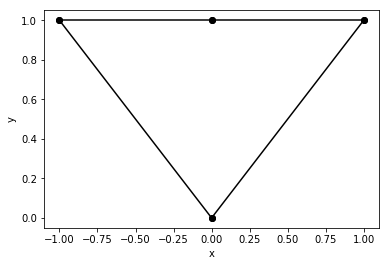

In [7]:
plt.plot(X_aiL[0],X_aiL[1],color='black', marker="o");
plt.xlabel('x');
plt.ylabel('y');

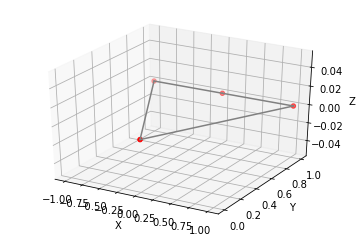

In [8]:
X_Lai = np.einsum('Lia->Lai', X_Lia)
fig = plt.figure()
ax = plt.axes(projection="3d")
for X_ai in X_Lai:
    x_line, y_line, z_line = X_ai
    ax.plot3D(x_line, y_line, z_line, 'gray');
x_points, y_points, z_points = np.einsum('Ia->aI', X_Ia)
ax.scatter3D(x_points, y_points, z_points, color='red');
ax.set_xlabel('X');
ax.set_ylabel('Y');
ax.set_zlabel('Z');

## Construction of orthogonal basis
To provide a robust scheme for the identification of two tangential
vectors the concept presented here has been applied

https://orbit.dtu.dk/files/126824972/onb_frisvad_jgt2012_v2.pdf

In [9]:
Tu_La = X_Lia[..., 1, :] - X_Lia[..., 0, :]
I = np.fabs(Tu_La[..., 0]) > np.fabs(Tu_La[..., 2])
Tvv_La = np.c_[0 * Tu_La[..., 0], -Tu_La[..., 2], Tu_La[..., 1]]
Tvv_La[I, :] = np.c_[-Tu_La[I, 1], Tu_La[I, 0], 0 * Tu_La[I, 0]]
Tw_La = np.einsum('abc,...a,...b->...c', EPS, Tu_La, Tvv_La)
Tv_La = np.einsum('abc,...a,...b->...c', EPS, Tw_La, Tu_La)
T_Lba = np.einsum('...bLa->...Lba', np.array([Tu_La, Tv_La, Tw_La]))

### Normalize to get orthonormal basis

In [10]:
norm_T_lb = 1. / np.sqrt(np.einsum(
    '...lba,...lba->...lb', T_Lba, T_Lba)
)
nT_Lba = np.einsum('...lb,...lba->...lba', norm_T_lb, T_Lba)
nT_Lba

array([[[-0.70710678,  0.70710678,  0.        ],
        [-0.70710678, -0.70710678,  0.        ],
        [ 0.        ,  0.        ,  1.        ]],

       [[ 0.70710678,  0.70710678,  0.        ],
        [-0.70710678,  0.70710678,  0.        ],
        [ 0.        ,  0.        ,  1.        ]],

       [[-1.        ,  0.        ,  0.        ],
        [ 0.        , -1.        ,  0.        ],
        [ 0.        ,  0.        ,  1.        ]],

       [[ 1.        ,  0.        ,  0.        ],
        [ 0.        ,  1.        ,  0.        ],
        [ 0.        ,  0.        ,  1.        ]]])

## Coordinates of interfaces between two linked grains
\begin{align}
    x^{\mathrm{m}}_{La} = \frac{1}{2} \delta_{ii} x_{Lia}
\end{align}

\begin{align}
    \Delta x^{m}_{Lia} = x^{\mathrm{m}}_{La} - x_{Iia}
\end{align}

In [11]:
DELTA2 = np.identity(2)
Xm_La = np.einsum('ii,Lia->La', DELTA2, X_Lia) / 2
#Xm_La = (X_Lia[...,1,:] + X_Lia[...,0,:]) /2 
Xm_Lia = Xm_La[..., np.newaxis, :]
dXm_Lia = Xm_Lia - X_Lia
dXm_Lia

array([[[-0.5,  0.5,  0. ],
        [ 0.5, -0.5,  0. ]],

       [[ 0.5,  0.5,  0. ],
        [-0.5, -0.5,  0. ]],

       [[-0.5,  0. ,  0. ],
        [ 0.5,  0. ,  0. ]],

       [[ 0.5,  0. ,  0. ],
        [-0.5,  0. ,  0. ]]])

## Displacement of nodes $U_{Ia}$ and rotation of aggregates $\Phi_{Ia}$

In [12]:
U_Ia = np.array(
    [
        [0.4, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]
    ], dtype=np.float_
)

Phi_Ia = np.array(
    [
        [0, 0, 0.1 * np.pi],
        [0, 0, -0.1 * np.pi],
        [0, 0, 0.1 * np.pi],
        [0.3 * np.pi, 0, 0.1 * np.pi]
    ], dtype=np.float_
)

In [13]:
U_Lia = U_Ia[I_Li]

## Global displacement of interface points

### Translation of grains mapped to interfaces
Distribute the translation of a center of grain gravity $u_{Ia}$ to the interface $i$ of the link $L$
\begin{align}
U^{\mathrm{m,trans}}_{Lia} = U_{I_{[Li]}a}
\end{align}

In [14]:
Um_trans_Lia = U_Ia[I_Li]

### Rotations of aggregates
\begin{align}
    U^{\mathrm{m,rot}}_{Lia} =  \epsilon_{abc}  \Phi_{Lib} \Delta x^{\mathrm{m}}_{Lic}  
\end{align}

In [15]:
Phi_Lia = Phi_Ia[I_Li]
Um_rot_Lia = np.einsum('abc,...b,...c->...a',
                   EPS, Phi_Lia, dXm_Lia)

The  global displacement at the interface is 
\begin{align}
    U^{\mathrm{m}}_{Lia} = U^{\mathrm{m,trans}}_{Lia} + U^{\mathrm{m,rot}}_{Lia}
\end{align}

In [16]:
Um_Lia = Um_trans_Lia + Um_rot_Lia
Um_Lia

array([[[ 0.24292037, -0.15707963,  0.        ],
        [ 0.15707963,  0.15707963,  0.        ]],

       [[ 0.24292037,  0.15707963,  0.        ],
        [ 0.15707963, -0.15707963, -0.4712389 ]],

       [[ 0.        ,  0.15707963,  0.        ],
        [ 0.        ,  0.15707963,  0.        ]],

       [[ 0.        , -0.15707963,  0.        ],
        [ 0.        , -0.15707963,  0.        ]]])

### Plot the displacements

In [17]:
Um_trans_aiL = np.einsum('Lia->aiL',Um_trans_Lia)
XU_aiL = X_aiL + Um_trans_aiL
XUm_aiL = np.einsum('Lia->aiL',(Xm_Lia + Um_Lia))
XUIm_aiL = np.concatenate(
    [
        np.einsum('iaL->aiL',
                  np.array([XU_aiL[:,0,...], XUm_aiL[:,0,...]])),
        np.einsum('iaL->aiL',
                  np.array([XU_aiL[:,1,...], XUm_aiL[:,1,...]]))
    ], axis=-1
)

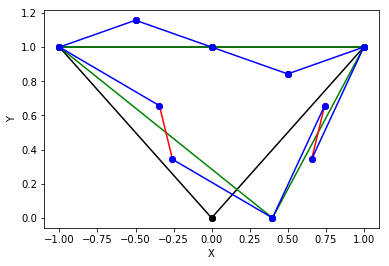

In [18]:
plt.plot(X_aiL[0],X_aiL[1],color='black', marker="o");
plt.plot(XU_aiL[0],XU_aiL[1],color='green', marker="o");
plt.plot(XUm_aiL[0], XUm_aiL[1],color='red', marker="o");
plt.plot(XUIm_aiL[0], XUIm_aiL[1],color='blue', marker="o");
plt.xlabel('X');
plt.ylabel('Y');

In [19]:
XU_Lai = np.einsum('aiL->Lai',XU_aiL)
XUm_Lai = np.einsum('aiL->Lai',XUm_aiL)
XUIm_Lai = np.einsum('aiL->Lai',XUIm_aiL)

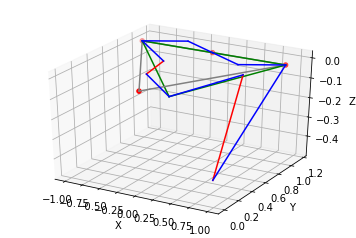

In [20]:
fig = plt.figure()
ax = plt.axes(projection="3d")
for X_ai,XU_ai, XUm_ai in zip(X_Lai, XU_Lai, XUm_Lai):
    x_line, y_line, z_line = X_ai
    ax.plot3D(x_line, y_line, z_line, 'gray');
    x_line, y_line, z_line = XU_ai
    ax.plot3D(x_line, y_line, z_line, 'green')
    x_line, y_line, z_line = XUm_ai
    ax.plot3D(x_line, y_line, z_line, 'red')
for XUIm_ai in XUIm_Lai:
    x_line, y_line, z_line = XUIm_ai
    ax.plot3D(x_line, y_line, z_line, 'blue')    
ax.scatter3D(x_points, y_points, z_points, color='red');
ax.set_xlabel('X');
ax.set_ylabel('Y');
ax.set_zlabel('Z');

### Local displacement at interface points
Transform the displacements at the interface planes $i$ to the local base of the link $L$
\begin{align}
    u^\mathrm{m}_{Lib} = T_{Lba} U^\mathrm{m}_{Lia}
\end{align}

In [21]:
um_Lib = np.einsum('...Lba,...Lia->...Lib', nT_Lba, Um_Lia)

## Relative displacements at the interface $L$
The relative displacement
at the interface between the grains $L0$ and $L1$ along the link $L$
is given as
\begin{align}
    u^{\mathrm{m}}_{La} = (-1)^i \delta_{ii} u^{\mathrm{m}}_{Lia}
\end{align}
or simply
\begin{align}
    u^{\mathrm{m}}_{La} =  u^{\mathrm{m}}_{L1a} - u^{\mathrm{m}}_{L0a}.
\end{align}

In [22]:
switch_sign = np.array([-1,1],dtype=np.float_)
em_Lb = np.einsum('i,ii,...Lia->...La', 
                  switch_sign, DELTA2, um_Lib)
em_Lb

array([[ 0.28284271, -0.16144558,  0.        ],
       [-0.28284271, -0.16144558, -0.4712389 ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

## Definition of the kinematic operator $B_{pLiac}$
Define the kinematic operator as a multidimensional array
\begin{align}
    u^{\mathrm{m}}_{La} &= (-1)^i \delta_{ii} u^{\mathrm{m}}_{Lia} \\
    &= (-1)^i \delta_{ii} T_{Lab} U^\mathrm{m}_{Lib}  \\
    &= (-1)^i \delta_{ii} T_{Lab} (U^{\mathrm{m,trans}}_{Lib} + U^{\mathrm{m,rot}}_{Lib})\\
    &= (-1)^i \delta_{ii} T_{Lab} (U_{Lib} + \epsilon_{bcd}  \Phi_{Lic} \Delta x^{\mathrm{m}}_{Lid} ) \\
    &= S_{Liac} U_{Lic} +  S_{Liab} \epsilon_{bcd} \Delta x^{\mathrm{m}}_{Lid} \Phi_{Lic} 
\end{align}Definition of the kinematic operator $B_{pLiac}$

In [23]:
S_Liac = np.einsum('i,ii,...Lac->...Liac', 
                    switch_sign, DELTA2, nT_Lba)

To provide a compact mapping, let us stack the global displacement variables $U_{Lib}$ and $\Phi_{Lic}$ along a new dimension $p$ to separate the kinematic operator from the unknown nodal variables
\begin{align}
  {u}^{\mathrm{m}}_{La} = \mathcal{B}_{pLiac} \mathcal{U}_{pLiac} 
\end{align}
where
\begin{align}
\mathcal{B}_{pLiac} =   \left[
  \begin{array}{cc}
  S_{Liac},& S_{Liab} \epsilon_{bcd} \Delta x^{\mathrm{m}}_{Lid}
  \end{array}
  \right]
\end{align}
and
\begin{align}
  \mathcal{U}_{pLiac} =   \left[
  \begin{array}{cc}
  U_{Lic},& \Phi_{Lic}
  \end{array}
  \right]
\end{align}

In [24]:
B_pLiac = np.array([S_Liac, np.einsum('Liab,bcd,Lid->Liac', S_Liac, EPS, dXm_Lia)])

In [25]:
U_pLia = np.array([U_Lia, Phi_Lia])

In [26]:
uu_m_La = np.einsum('pLiac,pLic->La', B_pLiac, U_pLia)

Verify the equivalence of the rearanged kinematic operator with the step by step evaluation of the response performed earlier.

In [27]:
uu_m_La - em_Lb

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

The implementation of the kinematic operator mapping the nodal displacements and rotations 
that can be cached as a property in the domain object looks as follows

In [32]:
X_Ia = np.array([[0,0,0],
                 [1,0,0]], np.float_)
I_Li = np.array([[0,1]], np.int_)
X_Lia = X_Ia[I_Li]
DELTA2 = np.identity(2)
Xm_La = np.einsum('ii,Lia->La', DELTA2, X_Lia) / 2
Xm_Lia = Xm_La[..., np.newaxis, :]
dXm_Lia = Xm_Lia - X_Lia
switch_sign = np.array([-1, 1], dtype=np.float_)
S_Liac = np.einsum('i,ii,...Lac->...Liac',
                   switch_sign, DELTA2, nT_Lba)
B_pLiac = np.array(
    [S_Liac, np.einsum('Liab,bcd,Lid->Liac',
                       S_Liac, EPS, dXm_Lia)]
)
B_Lipac = np.einsum('pLiac->Lipac', B_pLiac)

In [46]:
D_ab = np.identity(3)
K_mtx = np.einsum('Lipab,Ljqcd,ac->Lipbjqd', B_pLiac, B_pLiac, D_ab)

In [47]:
print(K_mtx.reshape(-1,12,12))

[[[ 1.          0.          0.         ...  0.          1.
    0.        ]
  [ 0.70710678  0.70710678  0.         ...  0.70710678  0.70710678
    0.        ]
  [ 0.          1.          0.         ... -1.          0.
    0.        ]
  ...
  [ 0.70710678 -0.70710678  0.         ...  0.70710678 -0.70710678
    0.        ]
  [ 0.          0.         -1.         ...  0.          0.
    1.        ]
  [ 0.          0.         -1.         ...  0.          0.
    1.        ]]

 [[ 0.          1.          0.         ... -1.          0.
    0.        ]
  [-0.70710678  0.70710678  0.         ... -0.70710678  0.70710678
    0.        ]
  [-1.          0.          0.         ...  0.         -1.
    0.        ]
  ...
  [ 0.70710678  0.70710678  0.         ...  0.70710678  0.70710678
    0.        ]
  [ 0.          0.         -1.         ...  0.          0.
    1.        ]
  [ 0.          0.         -1.         ...  0.          0.
    1.        ]]

 [[ 0.70710678 -0.70710678  0.         ...  0.707106